In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
# from fastai.callbacks import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config

from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [3]:
bpp = 0.3
H_target = 2* bpp
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [4]:
logger = setup_file_logger()

In [5]:
config.use_si_flag = SiNetChannelIn.WithSideInformation

In [6]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 # 0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)


tfms =  get_transforms(do_flip=True,
                       flip_vert=False,
                       max_rotate=False,
                       max_zoom=0,
                       max_lighting=False,
                       max_warp=False)
batchsize = 32

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(tfms, size=(192, 192), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = None
gc.collect()
learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(baseline_autoencoder,SiNetChannelIn.NoSideInformation,target_bit_cost = H_target),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [7]:
model_fname =FileNameGenerator.create_fname(f'try2-MAE-l2reg-baseline-bpp0p{bpp*100:.0f}')
lrs = [1e-4] *4 + [1e-5] * 3 + [1e-6] *2 
model_fname

'2020-08-29try2-MAE-l2reg-baseline-bpp0p30'

In [8]:
config.si_loss_weight_alpha = 0
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
    
offset = 0
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0 :
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=False)])
    
    learn.save(f'{model_fname}-{i}')
    if i % 3 or i == len(lrs) - 1:
        !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
        !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,255.757736,333.455261,0.370939,08:24


iter 0: bpp = 0.101 imp-mean-var(0.55 0.25) total loss814.9  l2reg_loss=18.4autoencoder_loss_value=84.9si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.563 imp-mean-var(0.03 0.02) total loss328.0  l2reg_loss=17.3autoencoder_loss_value=49.4si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.498 imp-mean-var(0.04 0.04) total loss239.3  l2reg_loss=16.5autoencoder_loss_value=31.6si_loss=0.0feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,96.584793,87.911575,0.091904,08:23


iter 0: bpp = 0.049 imp-mean-var(0.04 0.04) total loss240.7  l2reg_loss=16.5autoencoder_loss_value=33.8si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.423 imp-mean-var(0.04 0.04) total loss156.0  l2reg_loss=16.1autoencoder_loss_value=25.3si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.353 imp-mean-var(0.04 0.04) total loss95.0  l2reg_loss=15.7autoencoder_loss_value=24.1si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30-1.pth to s3://dsin-us/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30-1.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,38.597569,35.185513,0.062728,08:23


iter 0: bpp = 0.035 imp-mean-var(0.04 0.03) total loss87.3  l2reg_loss=15.7autoencoder_loss_value=24.0si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.304 imp-mean-var(0.04 0.04) total loss40.5  l2reg_loss=15.3autoencoder_loss_value=22.0si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.300 imp-mean-var(0.06 0.05) total loss44.9  l2reg_loss=15.0autoencoder_loss_value=20.5si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30-2.pth to s3://dsin-us/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30-2.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,35.298122,35.823761,0.049696,08:22


iter 0: bpp = 0.029 imp-mean-var(0.05 0.05) total loss36.6  l2reg_loss=14.9autoencoder_loss_value=21.2si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.297 imp-mean-var(0.06 0.06) total loss36.1  l2reg_loss=14.6autoencoder_loss_value=19.1si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.296 imp-mean-var(0.06 0.06) total loss33.3  l2reg_loss=14.3autoencoder_loss_value=18.8si_loss=0.0feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,33.125687,34.127106,0.038510,08:23


iter 0: bpp = 0.030 imp-mean-var(0.06 0.06) total loss33.7  l2reg_loss=14.3autoencoder_loss_value=18.9si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.294 imp-mean-var(0.07 0.07) total loss32.8  l2reg_loss=14.0autoencoder_loss_value=18.9si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.294 imp-mean-var(0.07 0.07) total loss31.6  l2reg_loss=13.8autoencoder_loss_value=17.8si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30-4.pth to s3://dsin-us/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30-4.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29try2-MAE-l2reg-baseline-bpp0p30.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.030 imp-mean-var(0.08 0.07) total loss32.9  l2reg_loss=13.8autoencoder_loss_value=18.7si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.283 imp-mean-var(0.09 0.08) total loss35.4  l2reg_loss=13.6autoencoder_loss_value=18.8si_loss=0.0feat_loss_value=0.0


KeyboardInterrupt: 

In [ ]:
learn.save(f'{model_fname}-{i}')

!aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
!aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


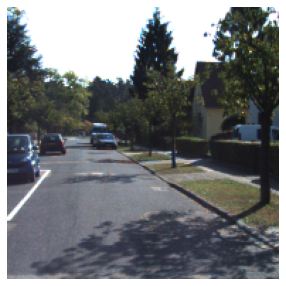

In [28]:
mt = learn.model.my_tuple[-3][0,...].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(5,5))
# # print(mn)

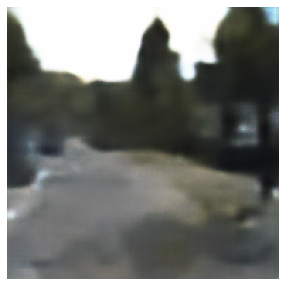

In [26]:
mt = learn.model.my_tuple[3][0,...].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(5,5))